In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
list_id = []
list_latitude = []
list_longitude = []
list_elevation = []
list_state = []

with open('data/ghcnd-stations.txt', 'r') as f:
    for line in f:
        # split the spaces
        list_line = line.split(' ')
        # delete the empty characters
        list_line = [line for line in list_line if line != '']

        # mapping file has the following columns:
        # id, latitude, longitude, elevation, state, name, gsn flag, wmo id
        # let's say that we don't care about name, gsn flag and wmo id
        # so we just want to keep the first 5 fields
        # we keep the state just for US contries, for other countries we put the first
        # two letters of the id
        if list_line[0][:2] == 'US':
            list_line = list_line[:5]
            state = list_line[4]
        else:
            list_line = list_line[:4]
            state = list_line[0][:2]
        
        list_id.append(list_line[0])
        list_latitude.append(list_line[1])
        list_longitude.append(list_line[2])
        list_elevation.append(list_line[3])
        list_state.append(state)


mapping_df = pd.DataFrame({
    'id': list_id,
    'latitude': list_latitude,
    'longitude': list_longitude,
    'elevation': list_elevation,
    'state': list_state
})

mapping_df['latitude'] = mapping_df['latitude'].astype(float)
mapping_df['longitude'] = mapping_df['longitude'].astype(float)
mapping_df['elevation'] = mapping_df['elevation'].astype(float)

mapping_df = mapping_df.set_index('id')



In [3]:
files = os.listdir('data')
files = [f for f in files if (('.csv' in f) and ('.gz' not in f))]

In [4]:
def format_dataset(filename):
    
    print(f"Working on file {filename}")

    dataset = pd.read_csv(filename, header=None, dtype={1: str, 7: str})

    dataset.columns = ['id', 'date', 'element', 'value', 'm_flag', 'q_flag', 's_flag', 'obs_time']
    dataset = dataset.loc[dataset['q_flag'].isna()]
    dataset = dataset.loc[dataset['element'].isin(['TMIN', 'TMAX'])]

    dataset['datetime'] = pd.to_datetime(dataset['date'], format='%Y%m%d')
    dataset = dataset[['datetime', 'id', 'value', 'element']]

    dataset = dataset.set_index(['datetime', 'id', 'element'])
    dataset = dataset['value'].unstack()

    dataset = dataset / 10 # temperature is in decimals of celsius degrees
    dataset = dataset.sort_index()

    # just keep US data
    us_ids = [a for a in list(dataset.index.get_level_values('id').unique()) if 'US' in a]
    dataset = dataset.loc[dataset.index.get_level_values('id').isin(us_ids)]

    return dataset

In [5]:
historical_temperatures = []

for file in files:
    temperature = format_dataset('data/' + file)

    historical_temperatures.append(temperature)

historical_temperatures = pd.concat(historical_temperatures)


Working on file data/2020.csv


In [ ]:
historical_temperatures = historical_temperatures.join(mapping_df)

In [ ]:
historical_temperatures.to_parquet('historical_temperatures.parquet')

In [6]:
# read the file with all the temperatures for each station
historical_temperatures = pd.read_parquet('historical_temperatures.parquet')
historical_temperatures

TMAX  TMIN  latitude  longitude  elevation state
datetime   id                                                           
2020-01-01 USC00010063  13.9  -2.8   34.2108   -87.1783      239.6    AL
           USC00010160  13.9  -1.1   32.9350   -85.9556      201.2    AL
           USC00010178  12.8  -1.7   33.1272   -88.1550       59.4    AL
           USC00010260  11.7  -2.2   34.9628   -87.3719      231.6    AL
           USC00010390  13.3   0.0   34.7753   -86.9508      210.0    AL
...                      ...   ...       ...        ...        ...   ...
2024-06-05 USW00014838  26.1  12.2   46.5458   -87.3794      202.7    MI
           USW00014924  21.7  12.2   48.9711   -97.2417      240.8    ND
           USW00022508  28.3  21.7   21.4833  -158.0333      257.9    HI
           USW00024020  25.0  11.7   40.5233  -101.0344      928.1    NE
           USW00025322  15.6   7.8   58.4111  -135.7089       12.2    AK

[11802244 rows x 6 columns]

<Axes: title={'center': 'Maximum Temperature for a single station [°C]'}, xlabel='datetime'>

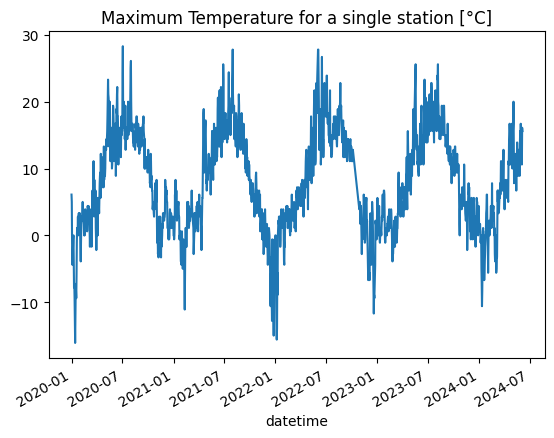

In [23]:
# pick a random station id and visualize the maximum temperature.
# it is clear that a seasonal pattern is present, this is a quite obvious
# and expected behavior
station_id = 'USW00025322'

historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().dropna().plot(
    title='Maximum Temperature for a single station [°C]'
)

Text(0.5, 1.0, 'Autocorrelation Plot of Maximum Temperature for a single station')

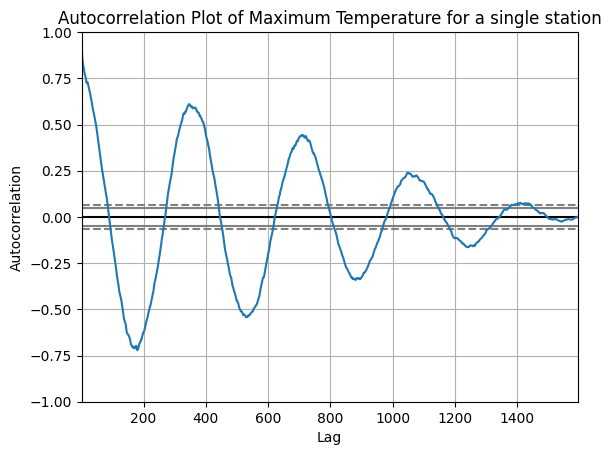

In [28]:
# autocorrelation plot of the maximum temperature of a single station
# as we expected, there is autocorrelation.
# The peaks correspond to alternate season, for example at 180 days lag we have a 
# minimum since the season is the opposite with respect to the season at day 0
# we have a maximum at 365 days lag since the season is the same
plt.figure()
pd.plotting.autocorrelation_plot(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().dropna())
plt.title('Autocorrelation Plot of Maximum Temperature for a single station')

In [33]:
# this kind of data is not stationary, so we have to do something!
# we should remove the seasonality and check again 
adfuller(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().dropna())

(-2.7895039115608733,
 0.05978877164125457,
 18,
 1575,
 {'1%': -3.434508723681996,
  '5%': -2.863376828187341,
  '10%': -2.567747894280675},
 7297.607450942058)

<Axes: title={'center': 'Deseasoned Maximum Temperature for a single station'}, xlabel='datetime'>

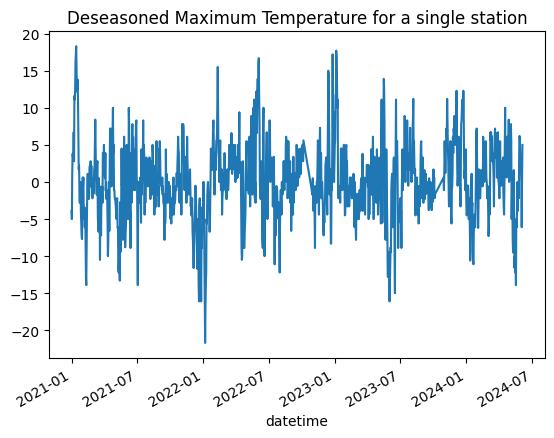

In [31]:
# let us now try to remove this kind of seasonality.
# an intuitive transformation could be to apply a diff(365), that is 
# subtracting the temperature of one year ago to each observations.
# In this way, we have the following
historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().diff(365).dropna().plot(title='Deseasoned Maximum Temperature for a single station')

Text(0.5, 1.0, 'Autocorrelation Plot for annual difference in Max Temperature for a single station')

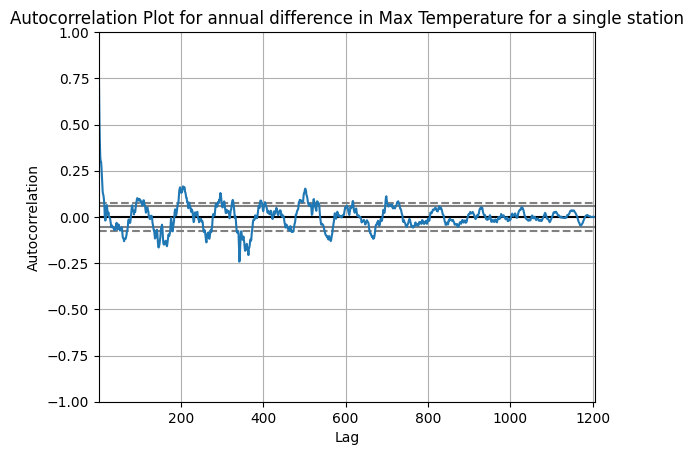

In [32]:
# we can now see that the autocorrelation plot is much better than before
# we still have some pattern that we could explore, but let us move forward
plt.figure()
pd.plotting.autocorrelation_plot(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().diff(365).dropna())
plt.title('Autocorrelation Plot for annual difference in Max Temperature for a single station')

In [34]:
# as expected, the deseasoned data behave better and it passes the stationarity test
adfuller(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().diff(365).dropna())

(-8.229160774250094,
 6.129338407224515e-13,
 5,
 1200,
 {'1%': -3.435811119579282,
  '5%': -2.8639515467824075,
  '10%': -2.5680539506944444},
 6304.018693897178)